# Crime data in context to immigration and population data

Two things that impact the data is the:

* 2015 - 2020 there was a change in policing strategy to Frontline 2020
* in 2020 there was a sharpe dip due to COIVD-19

In [323]:
# Dependencies
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from scipy import stats
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.stats import linregress

In [324]:
## functions ##

# load and clean crime datasets
def load_crime_data(datasets, path):
    df = pd.DataFrame()
    for dataset in datasets:
        # load the csv file
        file_path = Path(f"{path}{dataset}.csv")
        temp_df = pd.read_csv(file_path)
        # add the region
        temp_df["region"] = dataset
        df = pd.concat([df, temp_df])
    return df

In [325]:
# Load crime data set into pandas

regions = ["goldfields-esperance", "mandurah", "mirrabooka", "south_west", "armadale", "great_southern", "perth", "wheatbelt", "cannington", "joondalup", "mid_west-gascoyne", "plibara", "fremantle", "kimberley", "midland"]
metro_region = ["metropolitan", "regional"]

crime_all_df = load_crime_data(regions, 'crime-data/wa_crime_')
crime_metro_region_all_df = load_crime_data(metro_region, 'crime-data/wa_crime_')

crime_metro_region_all_df.head()

,Month and Year,Homicide Total,Murder,Attempted / Conspiracy to Murder,Manslaughter,Driving Causing Death,Recent Sexual Offence Total,Sexual Assault,Non-Assaultive Sexual Offences,Historical Sexual Offence Total,...,Fraud & Related Offences Total,Forgery,Fraud (Credit Card),Fraud (Not Elsewhere Classified),Breach of Violence Restraint Order Total,Breach of Family Violence Restraint Order,Breach of Violence Restraint Order,Breach of Police Order,Total Selected Miscellaneous Offences,region
0,Jan-07,9,4,2,0,3,160,104,56,62,...,513,31,0,482,346,250,63,33,NaN,metropolitan
1,Feb-07,2,0,0,0,2,130,87,43,75,...,452,17,0,435,341,231,81,29,1802.0,metropolitan
2,Mar-07,5,3,1,0,1,122,94,28,67,...,500,15,0,485,470,342,101,27,2273.0,metropolitan
3,Apr-07,0,0,0,0,0,139,88,51,206,...,393,5,0,388,351,272,50,29,1698.0,metropolitan
4,May-07,12,3,3,1,5,150,106,44,91,...,645,14,0,631,414,314,75,25,2133.0,metropolitan


In [326]:
# convert the dates
dates = pd.to_datetime(crime_metro_region_all_df['Month and Year'], format='%b-%y')
last_days = dates + pd.offsets.MonthEnd(1)
crime_metro_region_all_df['Month and Year'] = last_days
crime_metro_region_all_df = crime_metro_region_all_df.rename(columns={'Month and Year': 'Date'})
crime_metro_region_all_df = crime_metro_region_all_df.set_index('Date')

In [327]:
file_path = Path("other-data/immigration-data.csv")
immigration_df = pd.read_csv(file_path)
immigration_df = immigration_df[['DateTime', 'WA']]
dates = pd.to_datetime(immigration_df['DateTime'], format='ISO8601')
immigration_df['DateTime'] = dates
immigration_df = immigration_df.rename(columns={'DateTime': 'Date', 'WA': 'Total WA immigration'})
immigration_df['Date1'] = immigration_df['Date'].copy()

immigration_df = immigration_df.set_index('Date')

immigration_df.head()

,Total WA immigration,Date1
Date,,
2010-06-30,28866,2010-06-30
2010-09-30,29365,2010-09-30
2010-12-31,31897,2010-12-31
2011-03-31,34334,2011-03-31
2011-06-30,36425,2011-06-30


In [328]:

# change to quarterly data & resize the dataset to fit
crime_quarterly_df = crime_metro_region_all_df.resample('Q').sum()
crime_quarterly_df = crime_quarterly_df.loc['2010-06-01':'2022-07-01']

#remove the unwanted columns # crime_metro_region_all_df.columns.to_list()
crime_quarterly_df = crime_quarterly_df.drop(columns=[
 #'Homicide Total',
 'Murder',
 'Attempted / Conspiracy to Murder',
 'Manslaughter',
 'Driving Causing Death',
 #'Recent Sexual Offence Total',
 'Sexual Assault',
 'Non-Assaultive Sexual Offences',
 #'Historical Sexual Offence Total',
 'Sexual Assault.1',
 'Non-Assaultive Sexual Offences.1',
 #'Assault (Family) Total',
 'Serious Assault (Family)',
 'Common Assault (Family)',
 #'Assault (Non-Family) Total',
 'Serious Assault (Non-Family)',
 'Common Assault (Non-Family)',
 'Assault Police Officer',
 #'Threatening Behaviour (Family) Total',
 'Threatening Behaviour (Family)',
 'Possess Weapon to Cause Fear (Family)',
 #'Threatening Behaviour (Non-Family) Total',
 'Threatening Behaviour (Non-Family)',
 'Possess Weapon to Cause Fear (Non-Family)',
 #'Deprivation of Liberty Total',
 'Kidnapping / Child Stealing',
 'Deprivation of Liberty',
 #'Robbery Total',
 'Robbery (Business)',
 'Robbery (Non-Business)',
 'Unnamed: 31',
 #'Burglary Total',
 'Burglary (Dwelling)',
 'Burglary (Non-Dwelling)',
 'Stealing of Motor Vehicle',
 #'Stealing Total',
 'Stealing From Motor Vehicle (Contents or Parts)',
 'Stealing From Retail Premises (Shoplift)',
 'Stealing From Dwelling',
 'Stealing From Other Premises or Place',
 'Stealing as a Servant',
 'Stealing (Not Elsewhere Classified)',
 #'Property Damage Total',
 'Criminal Damage',
 'Damage',
 #'Arson Total',
 'Cause Bushfire',
 'Cause Damage by Fire',
 'Other Fire Related Offences',
 'Unnamed: 50',
 'Unnamed: 51',
 #'Drug Offences Total',
 'Drug Dealing',
 'Drug Possession',
 'Possession of Drug Paraphernalia',
 'Cultivate or Manufacture Drugs',
 'Other Drug Offences',
 #'Receiving and Possession of Stolen Property Total',
 'Possess Stolen Property',
 'Receiving Stolen Property',
 'Regulated Weapons Offences',
 'Unnamed: 62',
 'Graffiti',
 #'Fraud & Related Offences Total',
 'Forgery',
 'Fraud (Credit Card)',
 'Fraud (Not Elsewhere Classified)',
 #'Breach of Violence Restraint Order Total',
 'Breach of Family Violence Restraint Order',
 'Breach of Violence Restraint Order',
 'Breach of Police Order',
 'Total Selected Miscellaneous Offences',
 'region'
 ])

# add all the crime together
crime_quarterly_df['Total Crime'] = crime_quarterly_df.sum(axis=1)
crime_quarterly_df.head()

,Homicide Total,Recent Sexual Offence Total,Historical Sexual Offence Total,Assault (Family) Total,Assault (Non-Family) Total,Threatening Behaviour (Family) Total,Threatening Behaviour (Non-Family) Total,Deprivation of Liberty Total,Robbery Total,Burglary Total,Stealing Total,Property Damage Total,Arson Total,Drug Offences Total,Receiving and Possession of Stolen Property Total,Fraud & Related Offences Total,Breach of Violence Restraint Order Total,Total Crime
Date,,,,,,,,,,,,,,,,,,
2010-06-30,21,519,475,1758,2914,214,558,64,478,7205,15751,7979,205,4265,550,2063,1359,46378
2010-09-30,25,516,473,1978,2956,232,577,57,359,7668,15549,8089,288,3989,479,1541,1640,46416
2010-12-31,36,479,279,2583,3416,276,644,70,442,8839,17161,9420,309,3300,504,1542,1784,51084
2011-03-31,26,640,364,2664,3476,264,647,58,472,9524,18172,9239,327,3231,552,1742,1680,53078
2011-06-30,23,462,393,2225,2919,270,587,62,500,9282,18801,8437,218,3672,496,2077,2356,52780


In [329]:

# merge the datasets based on dates
immigration_vs_crime_df = crime_quarterly_df.merge(immigration_df, on="Date").copy()
immigration_vs_crime_df = immigration_vs_crime_df[['Total Crime', 'Total WA immigration', 'Date1']]
immigration_vs_crime_df['Total Crime'] = immigration_vs_crime_df['Total Crime'].astype(int)
immigration_vs_crime_df.head()


,Total Crime,Total WA immigration,Date1
Date,,,
2010-06-30,46378,28866,2010-06-30
2010-09-30,46416,29365,2010-09-30
2010-12-31,51084,31897,2010-12-31
2011-03-31,53078,34334,2011-03-31
2011-06-30,52780,36425,2011-06-30


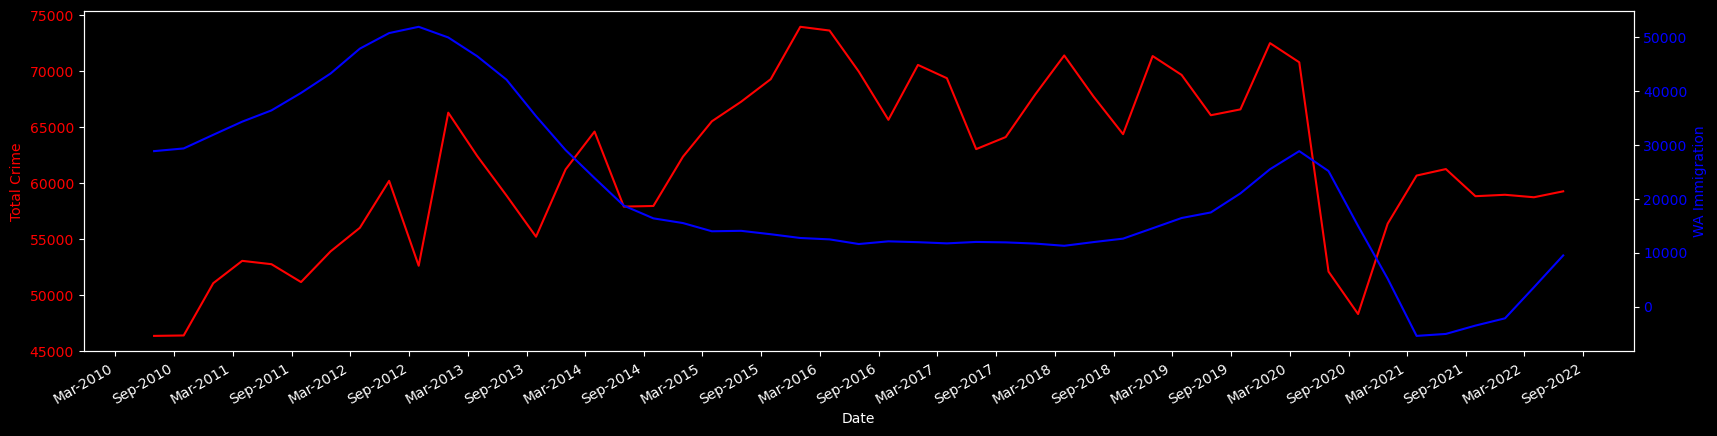

In [330]:
# create a line graph
fig, ax1 = plt.subplots() 

fig.set_size_inches(20, 5)

ax1.set_xlabel('Date') 
ax1.set_ylabel('Total Crime', color = 'red') 
ax1.plot(immigration_vs_crime_df['Date1'],immigration_vs_crime_df['Total Crime'], color = 'red') 
ax1.tick_params(axis ='y', labelcolor = 'red') 

# Adding Twin Axes

ax2 = ax1.twinx() 
  
ax2.set_ylabel('WA Immigration', color = 'blue') 
ax2.plot(immigration_vs_crime_df['Date1'],immigration_vs_crime_df['Total WA immigration'], color = 'blue')
ax2.tick_params(axis ='y', labelcolor = 'blue') 


# set monthly locator
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
# set formatter
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
# set font and rotation for date tick labels
plt.gcf().autofmt_xdate()
# Show plot
plt.show()

The r-squared is: 0.12560398096254619


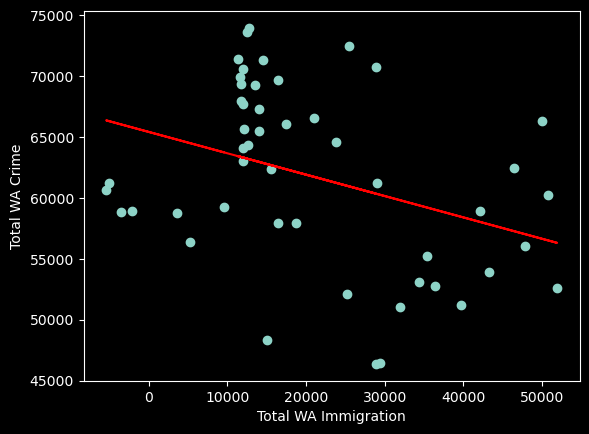

In [331]:
# Plot out rooms versus median house price
y_values = immigration_vs_crime_df['Total Crime']
x_values = immigration_vs_crime_df['Total WA immigration']

# Print out the r-squared value along with the plot.
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
#plt.annotate(line_eq,fontsize=15,color="red")
plt.ylabel('Total WA Crime')
plt.xlabel('Total WA Immigration')
print(f"The r-squared is: {rvalue**2}")
plt.show()

In [332]:
file_path = Path("other-data/population-data.csv")
population_df = pd.read_csv(file_path)

population_df = population_df.rename(columns={'Unnamed: 0': 'Date', 'Estimated Resident Population ;  Persons ;  Western Australia ;': 'WA Population'})
population_df = population_df.iloc[10:]

dates = pd.to_datetime(population_df['Date'], format='%b-%Y')
last_days = dates + pd.offsets.MonthEnd(1)
population_df['Date'] = last_days
population_df['Date1'] = population_df['Date'].copy()

population_df = population_df[['Date', 'WA Population', 'Date1']]
population_df = population_df.set_index('Date')

population_df.head()

,WA Population,Date1
Date,,
1981-09-30,1311284,1981-09-30
1981-12-31,1320221,1981-12-31
1982-03-31,1329700,1982-03-31
1982-06-30,1338899,1982-06-30
1982-09-30,1348096,1982-09-30


In [333]:
population_vs_crime_df = crime_quarterly_df.merge(population_df, on="Date").copy()

population_vs_crime_df = population_vs_crime_df[['Total Crime', 'WA Population', 'Date1']]
population_vs_crime_df['Total Crime'] = population_vs_crime_df['Total Crime'].astype(int)
population_vs_crime_df['WA Population'] = population_vs_crime_df['WA Population'].astype(int)

population_vs_crime_df['WA Population'] = population_vs_crime_df['WA Population']

population_vs_crime_df.head()


,Total Crime,WA Population,Date1
Date,,,
2010-06-30,46378,2290845,2010-06-30
2010-09-30,46416,2305415,2010-09-30
2010-12-31,51084,2319063,2010-12-31
2011-03-31,53078,2337611,2011-03-31
2011-06-30,52780,2353409,2011-06-30


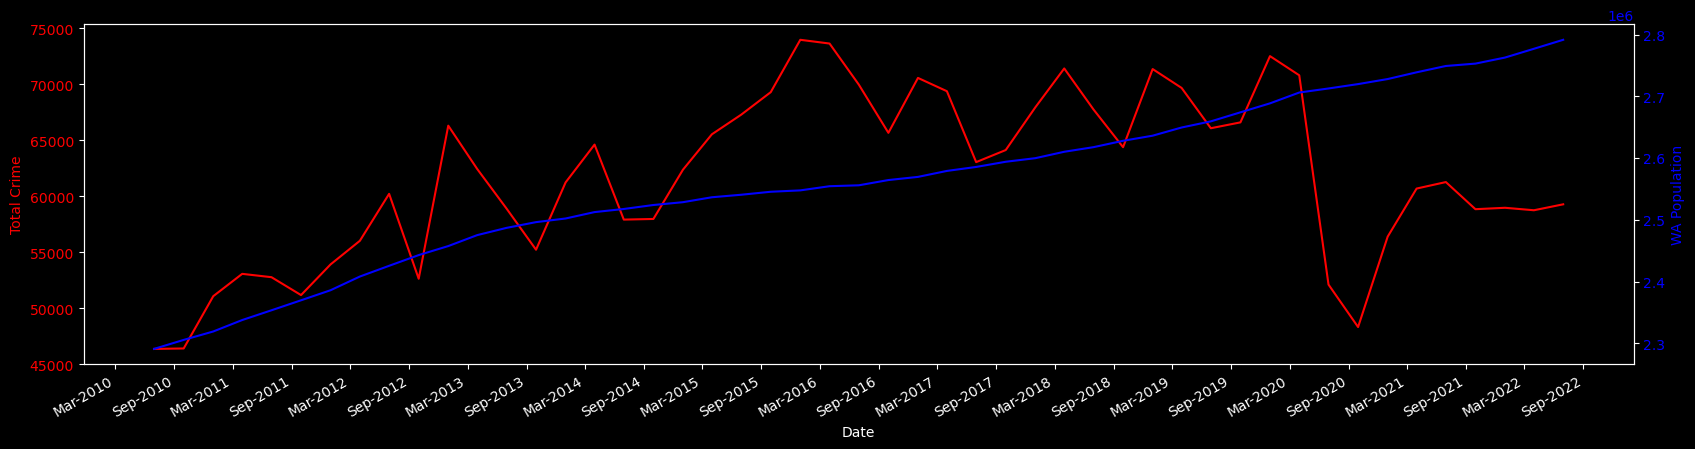

In [334]:
fig, ax1 = plt.subplots() 

fig.set_size_inches(20, 5)

ax1.set_xlabel('Date') 
ax1.set_ylabel('Total Crime', color = 'red')
ax1.plot(population_vs_crime_df['Date1'],population_vs_crime_df['Total Crime'], color = 'red')
ax1.tick_params(axis ='y', labelcolor = 'red')

# Adding Twin Axes

ax2 = ax1.twinx()
  
ax2.set_ylabel('WA Population', color = 'blue') 
ax2.plot(population_vs_crime_df['Date1'],population_vs_crime_df['WA Population'], color = 'blue')
ax2.tick_params(axis ='y', labelcolor = 'blue') 
 
# set monthly locator
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
# set formatter
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
# set font and rotation for date tick labels
plt.gcf().autofmt_xdate()

# Show plot

plt.show()

The r-squared is: 0.16146569813905678


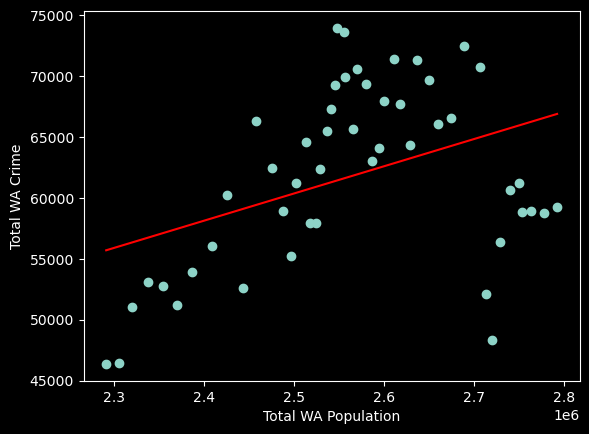

In [335]:
# Plot out rooms versus median house price
y_values = population_vs_crime_df['Total Crime']
x_values = population_vs_crime_df['WA Population']

# Print out the r-squared value along with the plot.
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(2300000, 210000),fontsize=10,color="red")
plt.ylabel('Total WA Crime')
plt.xlabel('Total WA Population')
print(f"The r-squared is: {rvalue**2}")
plt.show()